In [1]:
%matplotlib inline
import scipy.io as sio
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import scipy.signal as signal

import warnings
warnings.filterwarnings('ignore')

## Goals
* Read in tuned models from clfs.p 
* Evaluate each model on a sliding window 
* Plot results.

### Read in Data

### Subject 1 

In [2]:
data1 = sio.loadmat('../Data/data_cube_subject1.mat')
channel_labels = sio.loadmat('../Data/channel_label.mat')
data_matrix1 = data1['data_cube']
data_labels1 = data1['event_label'].ravel()

### Subject 2

In [64]:
data2 = sio.loadmat('../Data/data_cube_s2.mat')

data_matrix2 = data2['data_cube']
trlsel = data2['trlsel']
labels_hand = data2['labels_hand']
labels_condition = data2['labels_condition']
labels_hand_tokeep = data2['labels_hand_tokeep']

# Remove trials in which participant did not press (np)
labels_hand_tokeep_np = labels_hand_tokeep[np.where(trlsel==1),:][1]
np_to_be_removed = np.where(labels_hand_tokeep_np==0)

data_np = np.delete(data_matrix2,np_to_be_removed[0],2)
trlsel_np = np.delete(trlsel,np_to_be_removed[0],1)
labels_condition_np = np.delete(labels_condition,np_to_be_removed[0],0)

# Remove trials with muscle artifacts (ma)
labels_condition_np_ma = labels_condition_np[np.where(trlsel_np==1),:][1]
labels_hand_ma = labels_hand[np.where(trlsel_np==1),:][1]

# Divide data into condition A and B

data_A = np.delete(data_np, np.where(labels_condition_np_ma==1), 2)
data_B = np.delete(data_np, np.where(labels_condition_np_ma==0), 2)
data_matrix2 = np.concatenate([data_A, data_B], axis=-1)
labels_A = np.delete(labels_hand_ma, np.where(labels_condition_np_ma==1), 0)
labels_B = np.delete(labels_hand_ma, np.where(labels_condition_np_ma==0), 0)
data_labels2 = np.concatenate([labels_A, labels_B], axis=0).ravel()

In [67]:
data_A.shape

(64, 1937, 226)

### Lowpass Filter

In [56]:
def our_lowpass(data, freq=70):
    filt_data = data
    b, a = signal.butter(6, freq, 'low', analog = False, fs = 1000)
    for i in range(len(data)):
        filt_data[i] = signal.filtfilt(b, a, data[i])
    return filt_data
#data_matrix = our_lowpass(data=data_matrix)

### Read in Tuned Models
These models have been tuned using Daniel's hyper parameter tuning pipeline [link to daniels code], and saved in a pickle file.

In [6]:
fitted_models1 = None
fitted_models2 = None
with open('./bin/clfs.p', 'rb') as models:
    fitted_models1 = pickle.load(models)
with open('./bin/clfs_s2_NoFilt.p', 'rb') as models:
    fitted_models2 = pickle.load(models)

### Dimensionality Reduction, and Train Test Split

The functions defined below will handle the dimensionality reduction and the train/test split of our data for each sliding window to be modeled.

In [7]:
#function-type alias for use in type hints
function = type(lambda x: x)

def train_split(X:np.ndarray,y:np.ndarray):
    #3D Feature split
    all_idx = list(range(len(y)))
    train_idx, test_idx = train_test_split(all_idx, test_size=0.2)        
    X_train,X_test = X[:,:,train_idx],X[:,:,test_idx]
    y_train,y_test = y[train_idx],y[test_idx]
    return X_train, X_test,y_train,y_test

def lrp_split(X:np.ndarray,y:np.ndarray): 
    #Split 3D
    X_train, X_test,y_train,y_test = train_split(X,y)
    
    #Reduce Dim
    X_train = X_train[23,:,:] - X_train[7,:,:]
    X_test = X_test[23,:,:] - X_test[7,:,:]
    return X_train.T, X_test.T,y_train,y_test

def csp_transform_split(X:np.ndarray, y:np.ndarray, n_components:int):
    #Split data
    X_train, X_test,y_train,y_test = train_split(X,y)
    #Reshape for Mne
    dim_train = X_train.shape
    train = X_train.reshape(dim_train[2], dim_train[0], dim_train[1])
    dim_test = X_test.shape
    test = X_test.reshape(dim_test[2], dim_test[0], dim_test[1])
    
    #Fit on Training
    csp = mne.decoding.CSP(n_components)
    csp.fit(train, y_train)

    #Reduce Dim
    new_train = csp.transform(train)
    new_test = csp.transform(test)
    return new_train,new_test,y_train,y_test

def condition_split(X:np.ndarray, y:np.ndarray, trials_in_A:int=100):
    AX, BX = X[:,:,:trials_in_A], X[:,:,trials_in_A:]
    Ay, By = y[:trials_in_A], y[trials_in_A:]
    A_dict = {'X': AX, 'y': Ay}
    B_dict = {'X': BX, 'y': By}
    return A_dict, B_dict


### Sliding Functions

In [8]:
def sliding_window(X:np.ndarray,
                    window_length:int, 
                    step_size:int,
                    step:int):
    """This function will carve out a small window of the feature matrix X.
    The location and length of the window are specified by step_size,step, and window_length. 
    This function is designed to slide your window a distance |step_size| indices each step."""
    w_end_idx = step_size*(step + 1)
    w_start_idx = max( [1, w_end_idx - window_length] )
    return X[:, w_start_idx:w_end_idx, :]

def sliding_lrp(X:np.ndarray,
                y:np.ndarray, 
                window_length:int, 
                step_size:int,
                step:int,
                n_components:int,):
    """This function reduces the dimensionality of your feature matrix over a sliding window using LRP"""
    return lrp_split(sliding_window(X,window_length, step_size, step),y)

    
def sliding_csp_transform(X:np.ndarray,
                          y:np.ndarray, 
                          n_components:int,
                          window_length:int, 
                          step_size:int,
                          step:int):
    
    """This function selects the desired window of data and reduces the dimensionality of your feature matrix via CSP"""
    X_window = sliding_window(X,window_length, step_size, step)
    return csp_transform_split(X_window, y, n_components)
    

### Model Evaluation over Sliding Window

In [9]:
def sliding_accuracy(model_dict:dict,data_matrix:np.ndarray,
            data_labels:np.ndarray,
            window_length:int,
            step_size:int,local:bool=False):
    
    #Get tuned model and reduction method
    clf,slide_function = unpack_model_dict(model_dict)
        
    #Split Classes    
    A,B = condition_split(data_matrix,data_labels)
    
    #Number of sliding windows
    num_steps = get_num_steps(data_matrix,window_length,step_size)
    
    A_accs = []
    B_accs = []
    for step in range(num_steps):
        #Split and dim reduction
        X_train_A,X_test_A,y_train_A,y_test_A = slide_function(X=A['X'],y=A['y'], n_components=4,
                          window_length=window_length, 
                          step_size=step_size,
                          step=step)
        X_train_B,X_test_B,y_train_B,y_test_B = slide_function(X=A['X'],y=A['y'], n_components=4,
                          window_length=window_length, 
                          step_size=step_size,
                          step=step)
        
            
        clf.fit(X_train_A,y_train_A)
        A_acc = clf.score(X_test_A,y_test_A)
        A_accs.append(A_acc)

        clf.fit(X_train_B,y_train_B)
        B_acc = clf.score(X_test_B,y_test_B)
        B_accs.append(B_acc)

    
    return A_accs,B_accs



def get_num_steps(data_matrix:np.ndarray,window_length:int,
                    step_size:int):
    
    return int((len(data_matrix[1,:,1])-window_length)/step_size)


def unpack_model_dict(model_dict:dict,local:bool=False):
    
    slide_methods = {
    'lrp': sliding_lrp,
    'csp' :  sliding_csp_transform 
    }

    clfs = {
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'SVM': SVC(),
    'LDA': LDA()
    }
    
    model = model_dict['clf_type']
    grid = model_dict['clf']
    reduction_method = model_dict['reduction_method']
    slide_function = slide_methods[reduction_method]
    
    params = grid.best_params_
    clf = clfs[model]
    
    if local and model == 'LDA':
        #Return GridSearch Object to be tuned locally
        return clf,slide_function
        
    elif not local:
        #Set Global Hyperparameters
        if type(params) == dict:
            clf.set_params(**params)
        elif  type(params) == list:
            clf.set_params(*params)
        else:
            print('Paramter Type error')
        return clf, slide_function
    
    else:
        print('ERROR: Can only tune LDA locally due to high runtime.\n Make sure local=False for RF or other models')
        return 0
    


                    
    

    

### Data Visualization Functions

In [45]:
def condition_plots(model_dict:dict,data_matrix:np.ndarray,
            data_labels:np.ndarray,
            window_length:int,
            step_size:int,smooth_interval:int=20):
    
    """Single model accuracy subplots over a sliding window.
    First subplot shows Condition A accuracies in blue with a smoothed accuracy curve in orange. 
    A similar visualization for Condition B in the second subplot."""
    
    
    clf_type = model_dict['clf_type']
    reduction_method = model_dict['reduction_method']
    A,B = sliding_accuracy(model_dict,data_matrix,data_labels,window_length,step_size)
    
    smoothA,smoothB = [],[]
    for i in range(len(A)):
        smoothA.append(np.mean(A[i:i+smooth_interval]))
        smoothB.append(np.mean(B[i:i+smooth_interval]))
        
    fig, axs = plt.subplots(2,1,figsize=(15,12))
    
    axs[0].plot(A)
    axs[0].plot(smoothA)
    axs[0].set_title('Class A',fontsize=16)
    axs[0].set_xlabel('Time (ms)')
    axs[0].set_ylabel('Accuracy')
    
    axs[1].plot(B)
    axs[1].plot(smoothB)
    axs[1].set_title('Class B',fontsize=16)
    axs[1].set_xlabel('Time (ms)')
    axs[1].set_ylabel('Accuracy')
    
    fig.suptitle(f'{clf_type} & {reduction_method} \n Sliding window of length {window_length} and step size {step_size}', fontsize=18,fontweight="bold")
    
    return fig


def accuracy_plot(model_dict:dict,data_matrix:np.ndarray,
            data_labels:np.ndarray,
            window_length:int,
            step_size:int,smooth_interval:int=20,subject:str='Subject 2'):
    
    """Single model accuracy plot over a sliding window. Smoothed Condition A and B in same plot"""
    
    sns.set_style("dark")
    clf_type = model_dict['clf_type']
    reduction_method = model_dict['reduction_method']
    A,B = sliding_accuracy(model_dict,data_matrix,data_labels,window_length,step_size)
    
    smoothA,smoothB = [],[]
    for i in range(len(A)):
        smoothA.append(np.mean(A[i:i+smooth_interval]))
        smoothB.append(np.mean(B[i:i+smooth_interval]))
        
    fig = plt.figure(figsize=(12,3))
    
    #x = list(reversed([-x*8 for x in range(len(smoothA))]))
    
    plt.plot(smoothA,label = 'Condition A')
    plt.plot(smoothB,label='Condition B')
    plt.axhline(y=0.5, color='k', linestyle='--',alpha=0.5, label='Random Accuracy')
    plt.xlabel('Time Before Decision (ms)')
    plt.ylabel('Accuracy')
    
    
    #plt.title(f'Sliding window of length : {subject}, {clf_type}', fontsize=12,loc='left')
    fig.suptitle(f'{subject}: {clf_type},{reduction_method},{window_length}',fontsize=18,fontweight='bold')
    
    
    return fig


def  model_comparison_plot(model1:dict,model2:dict,data_matrix:np.ndarray,
            data_labels:np.ndarray,
            window_length:int,
            step_size:int,smooth_interval:int=20,local:list=[False,False],subject:str='Subject 1'):
    
    """Generate a figure comparing the sliding window prediction of two different models. 
    Smoothed average of Condition A & B plotted for each model in subplots figure."""
    
    A1,B1 = sliding_accuracy(model1,data_matrix,data_labels,window_length,step_size,local[0])
    A2,B2 = sliding_accuracy(model2,data_matrix,data_labels,window_length,step_size,local[1])

    sns.set_style("dark")
    smooth_interval= 20
    smoothA1,smoothB1,smoothA2,smoothB2 = [],[],[],[]
    for i in range(len(A1)):
        smoothA1.append(np.mean(A1[i:i+smooth_interval]))
        smoothB1.append(np.mean(B1[i:i+smooth_interval]))
        smoothA2.append(np.mean(A2[i:i+smooth_interval]))
        smoothB2.append(np.mean(B2[i:i+smooth_interval]))

    fig, axs = plt.subplots(2,1,figsize=(20,10),sharex=True, sharey=True, squeeze=True)
    
    title1 = model1['clf_type']
    title2 = model2['clf_type']

    if local[0]:
        title1+=': Locally Tuned Hyperparameters'
        
    if local[1]:
        title2+=': Locally Tuned Hyperparameters'
        
        
        
    x = list(reversed([-x*8 for x in range(len(smoothA1))]))

    axs[0].plot(x,smoothA1,label = 'Condition A')
    axs[0].plot(x,smoothB1,label='Condition B')
    axs[0].set_title(title1,fontsize=20,fontweight = 'bold',loc='left')
    axs[0].set_xlabel('Time (ms)')
    axs[0].set_ylabel('Accuracy')
    axs[0].axhline(y=0.5, color='k', linestyle='--',alpha=0.5, label='Random Accuracy')
    #axs[0].set_ylim([0.4,0.8])
    axs[0].legend()

    axs[1].plot(x,smoothA2,label = 'Condition A')
    axs[1].plot(x,smoothB2,label='Condition B')
    axs[1].set_title(title2,fontsize=20,fontweight = 'bold',loc='left')
    axs[1].set_xlabel('Time (ms)')
    axs[1].set_ylabel('Accuracy')
    axs[1].axhline(y=0.5, color='k', linestyle='--',alpha=0.8, label='Random Accuracy')
    #axs[1].set_ylim([0.4,0.8])
    axs[1].legend()


    plt.suptitle(f'{subject}: Predictions on {window_length}ms Window', fontsize=24,fontweight="bold",va='center')
    plt.tight_layout()

    return fig

In [46]:
#Subject 1
s1_lda = fitted_models1[4]
s1_rf = fitted_models1[0]

#Subject 2
s2_lda = fitted_models2[4]
s2_rf = fitted_models2[0]

# Generate Plots:

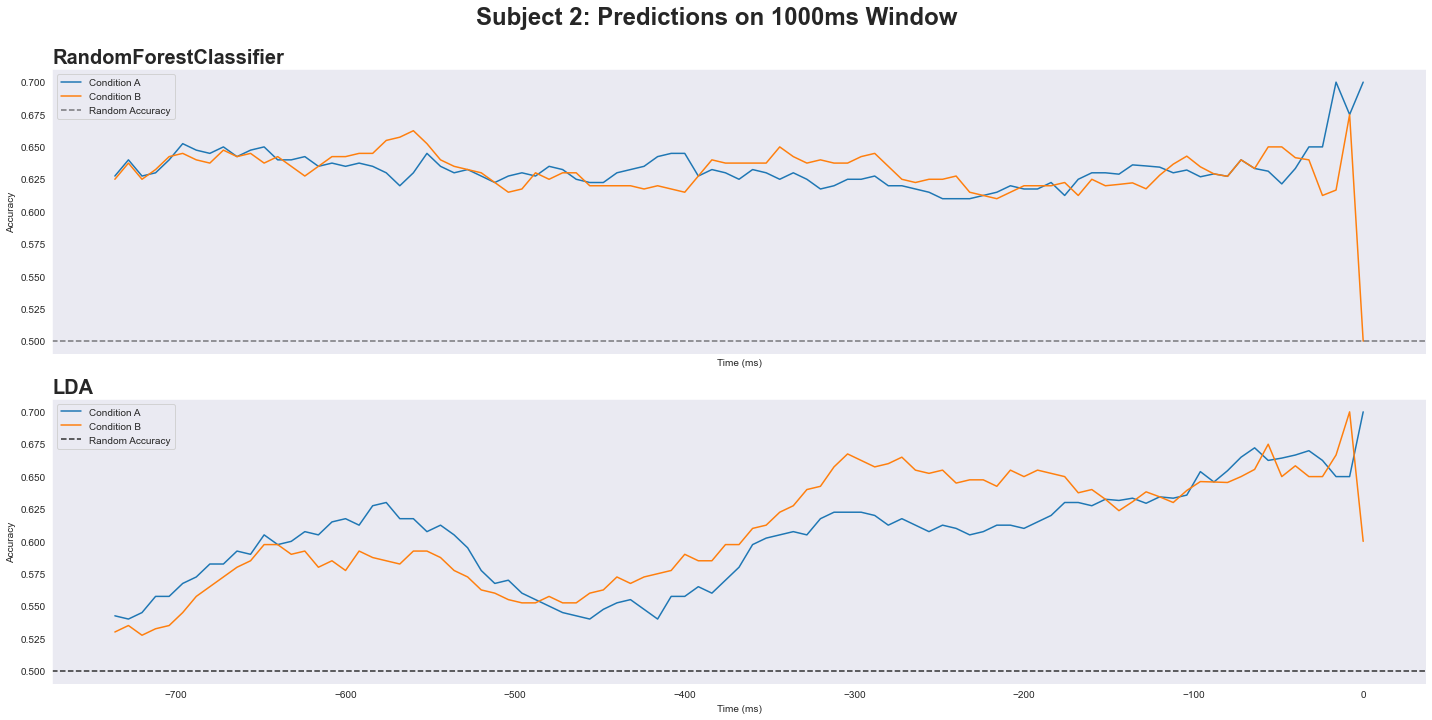

In [47]:
fig = model_comparison_plot(s2_rf,s2_lda,data_matrix2,data_labels2,window_length=1000,step_size=10,subject='Subject 2')

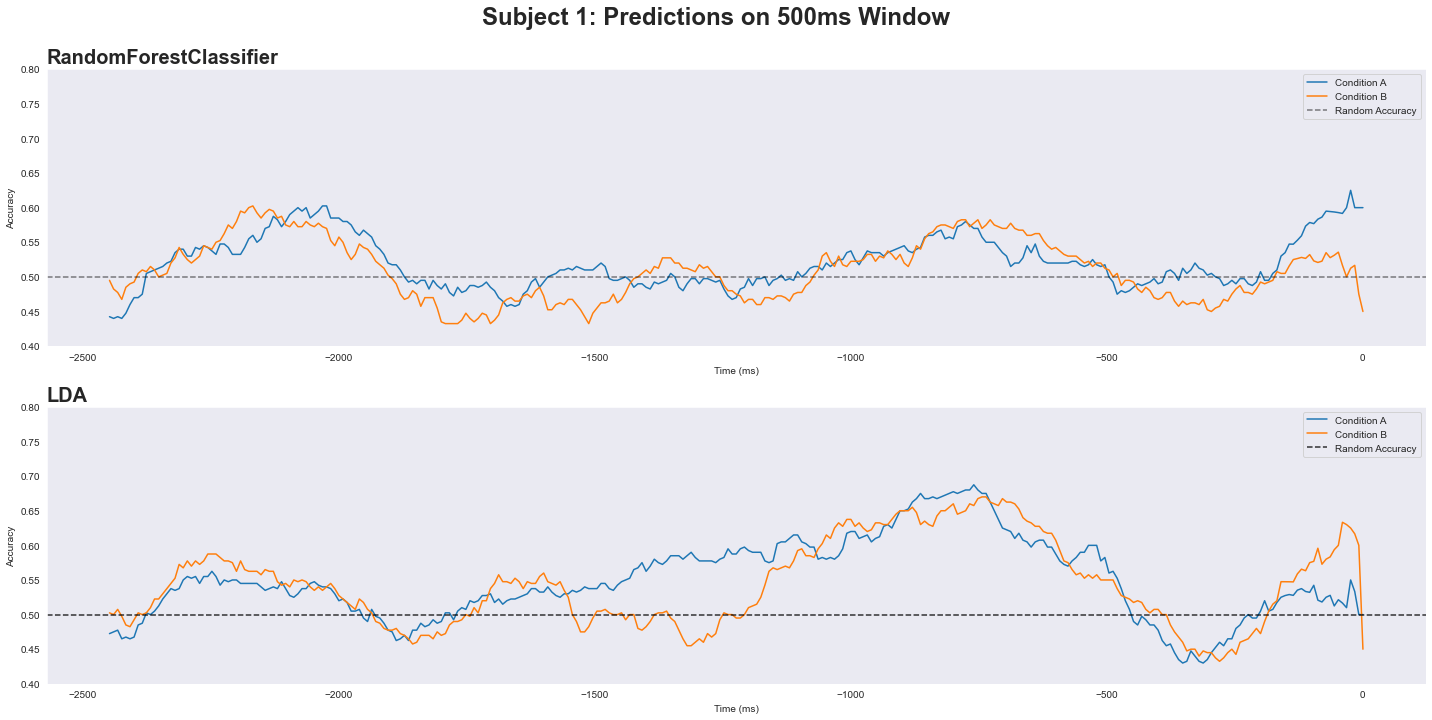

In [44]:
fig = model_comparison_plot(s1_rf,s1_lda,data_matrix1,data_labels1,window_length=500,step_size=10)

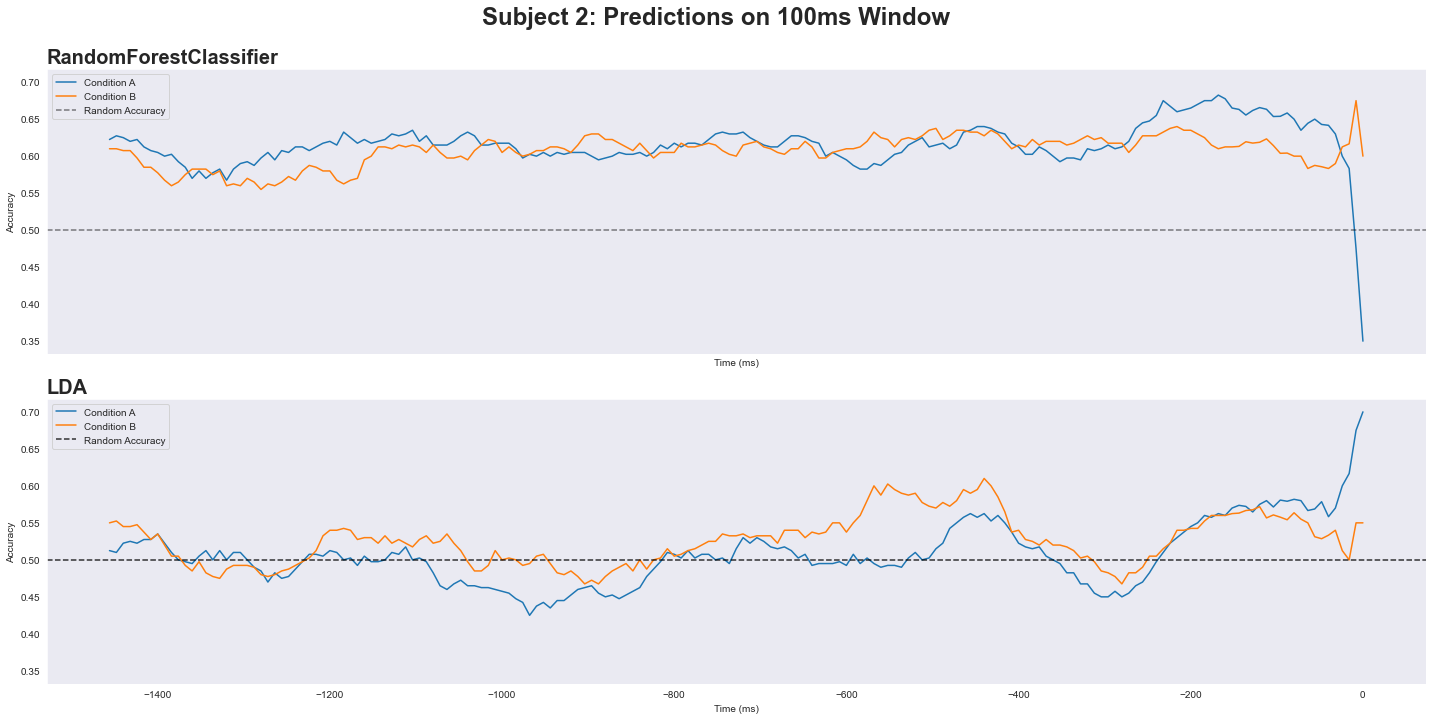

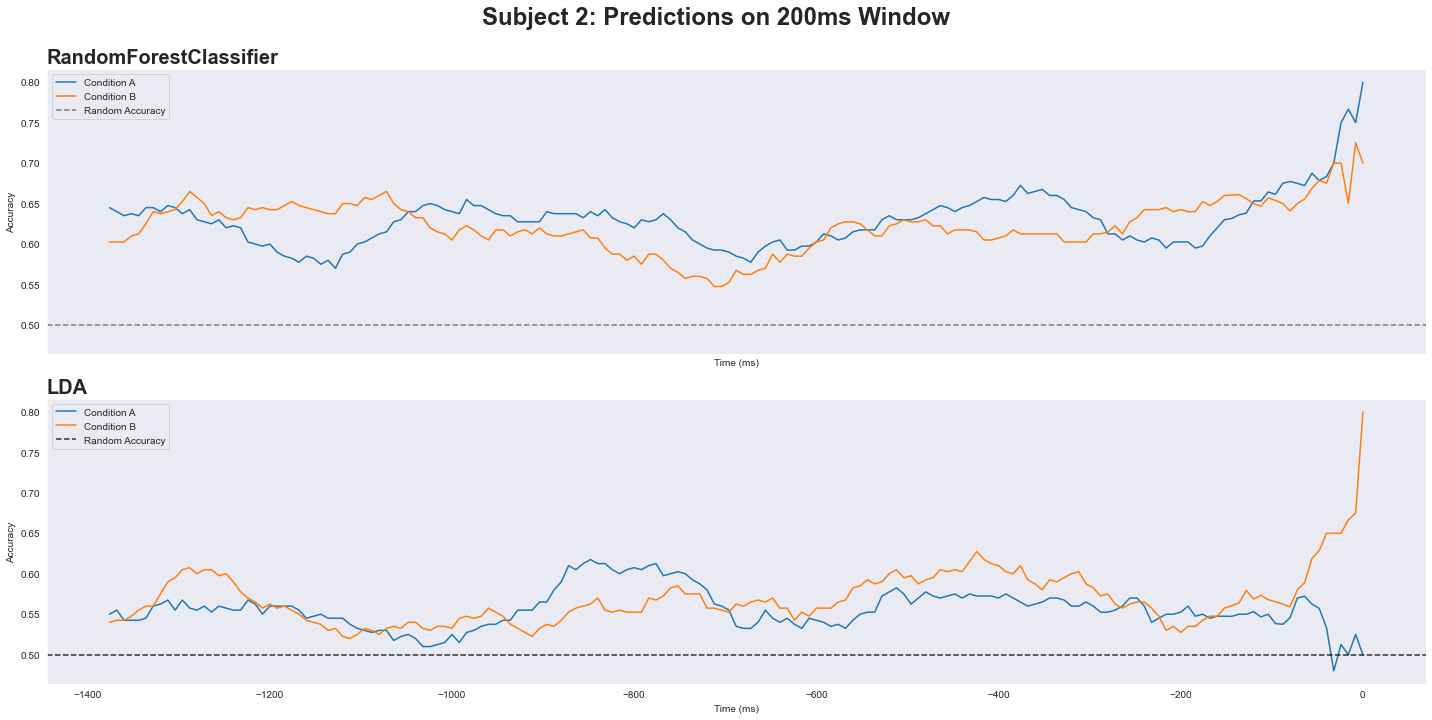

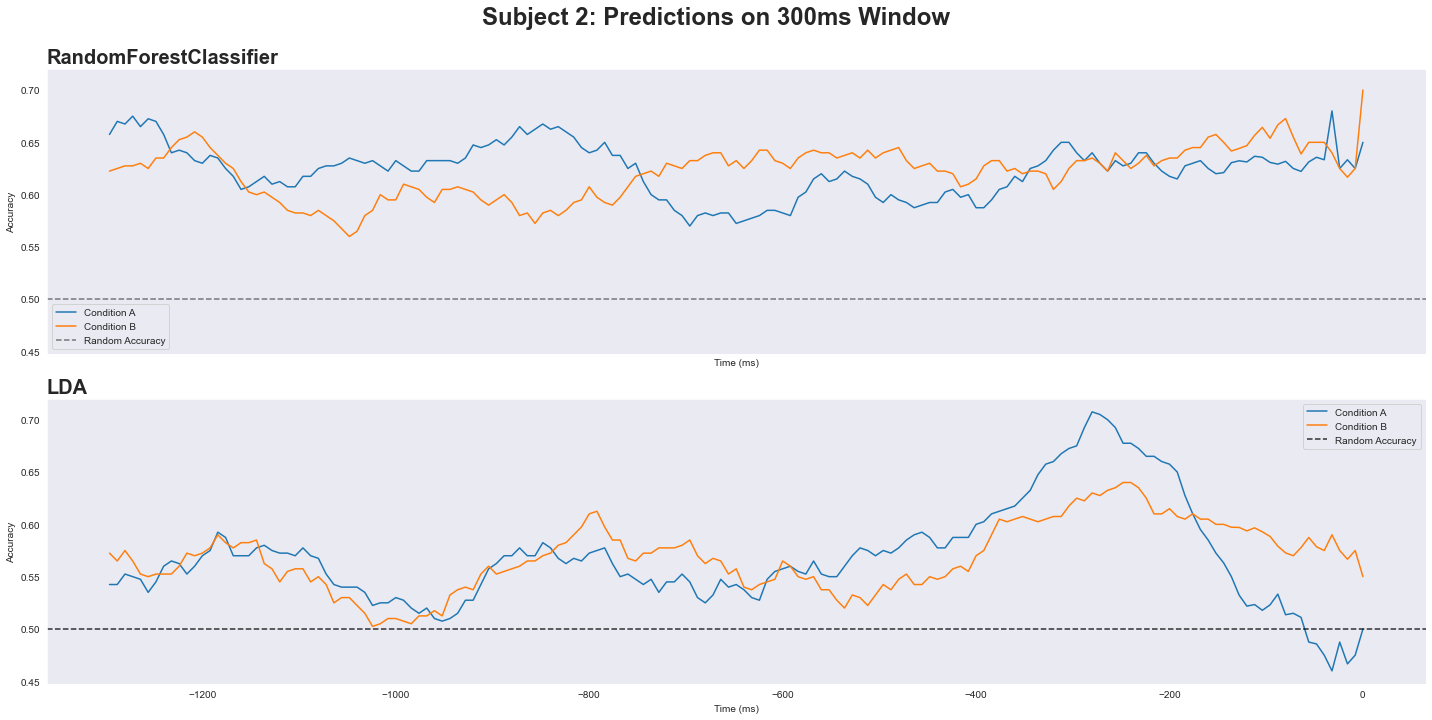

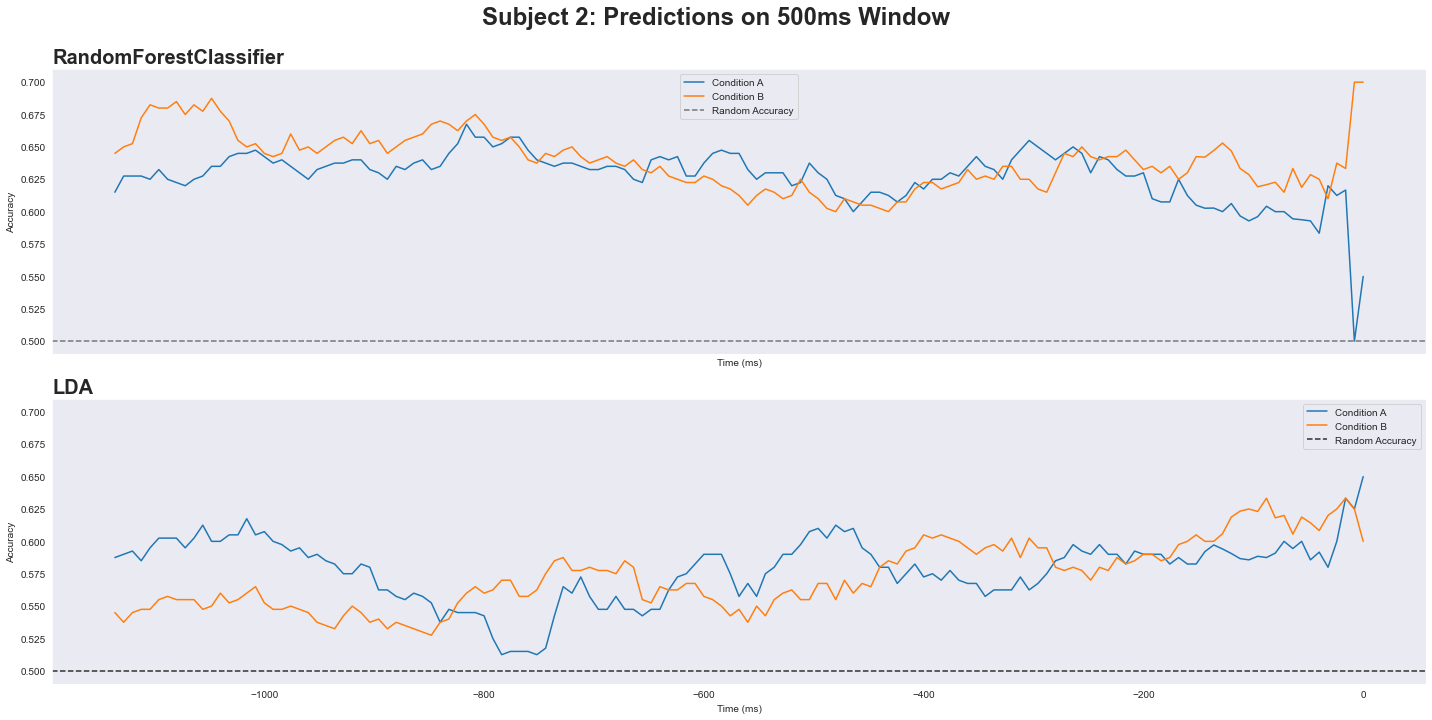

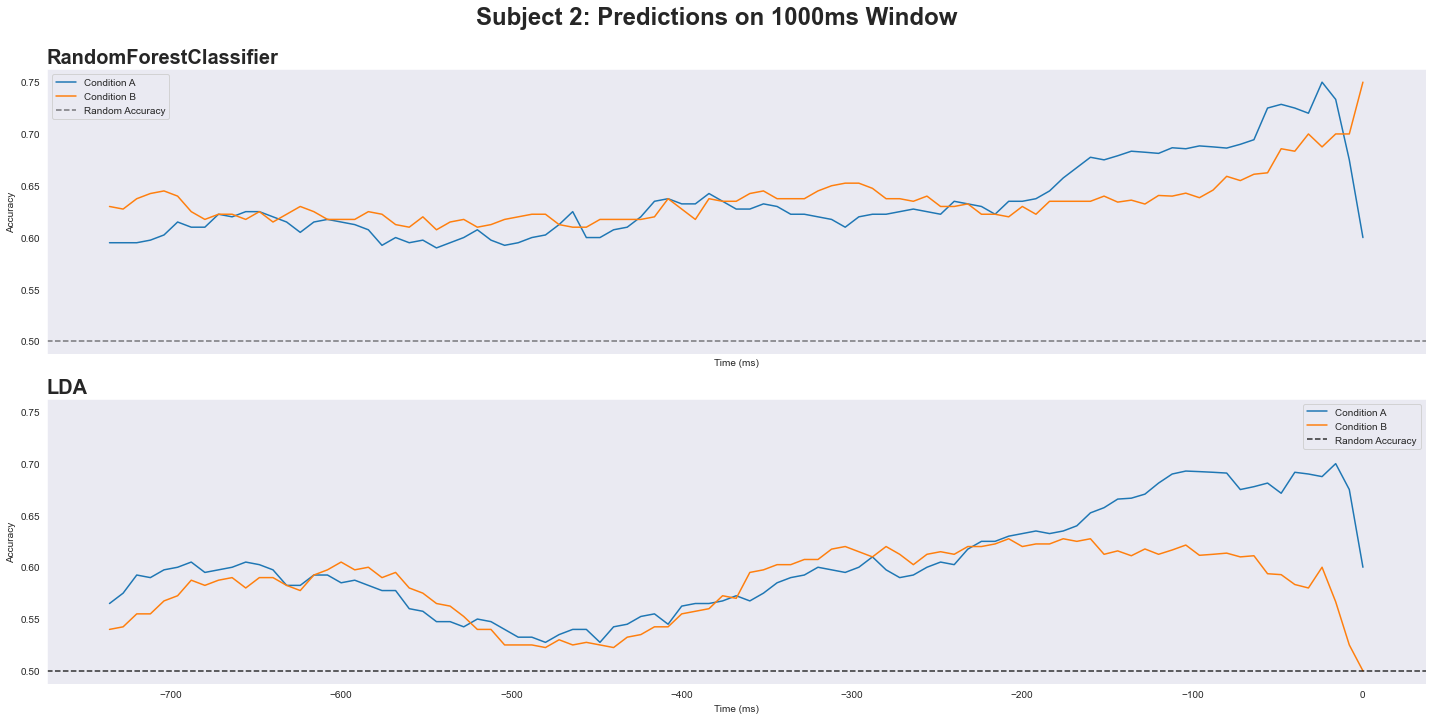

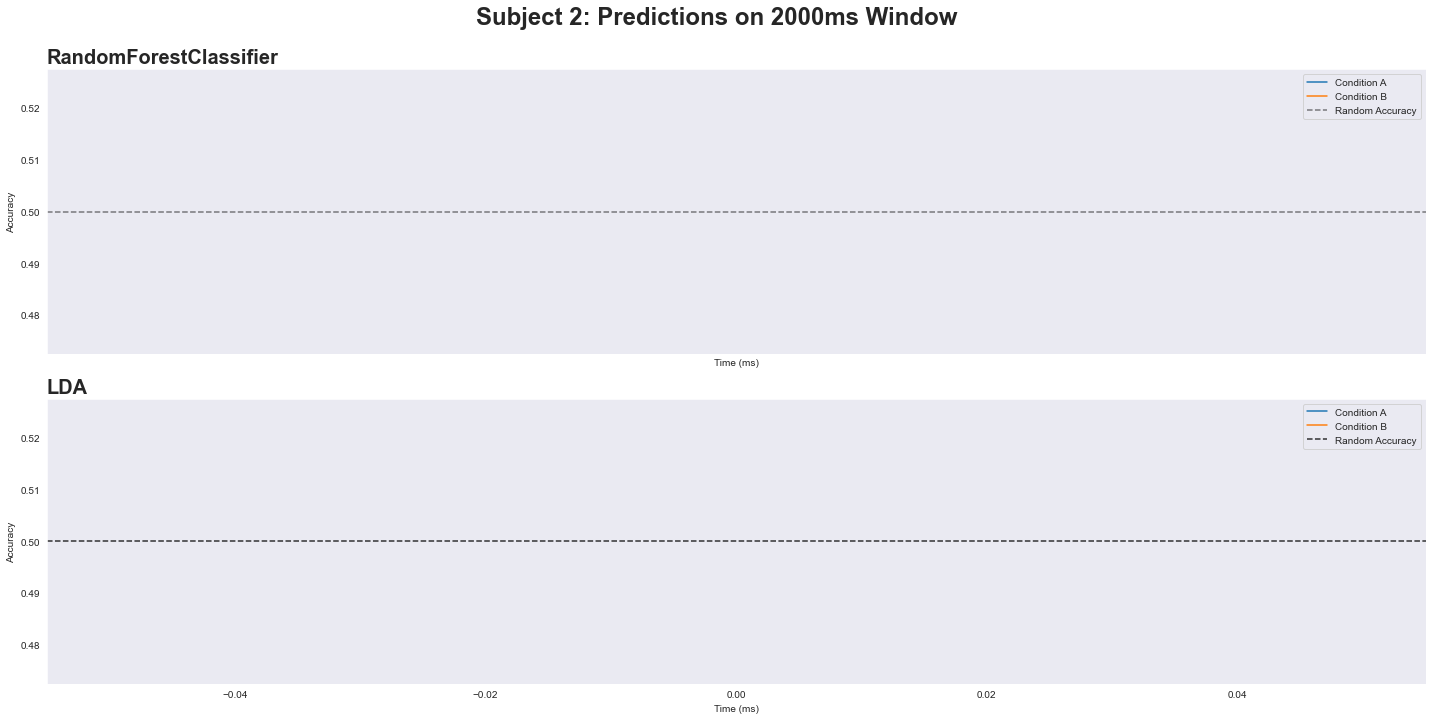

In [50]:
for i in [100,200,300,500,750,1000]:
    #Comparison Fig Subject 2
    fig = model_comparison_plot(s2_rf,s2_lda,data_matrix2,data_labels2,window_length=i,step_size=10,subject = 'Subject 2')
    title = fig._suptitle.get_text()
    fig.savefig(f'../Data/Model_Comparison/{title}.png')
    

In [127]:
sns.set_style("dark")




#Filter
#data1 = our_lowpass(data_matrix1,freq=70)
#data2 = our_lowpass(data_matrix2,freq=70)


#Split
A1,B1 =condition_split(data_matrix1,data_labels1)
A2,B2 = condition_split(data_matrix2,data_labels2,trials_in_A=226)

#Channel 24 and Left/Right Split
A1L = np.mean(A1['X'][23,:,:][:,np.where(A1['y']==0)],axis=2).ravel()
A1R = np.mean(A1['X'][23,:,:][:,np.where(A1['y']==1)],axis=2).ravel()
B1L = np.mean(B1['X'][23,:,:][:,np.where(B1['y']==0)],axis=2).ravel()
B1R = np.mean(B1['X'][23,:,:][:,np.where(B1['y']==1)],axis=2).ravel()


A2L = np.mean(A2['X'][23,:,:][:,np.where(A2['y']==0)],axis=2).ravel()
A2R = np.mean(A2['X'][23,:,:][:,np.where(A2['y']==1)],axis=2).ravel()
B2L = np.mean(B2['X'][23,:,:][:,np.where(B2['y']==0)],axis=2).ravel()
B2R = np.mean(B2['X'][23,:,:][:,np.where(B2['y']==1)],axis=2).ravel()




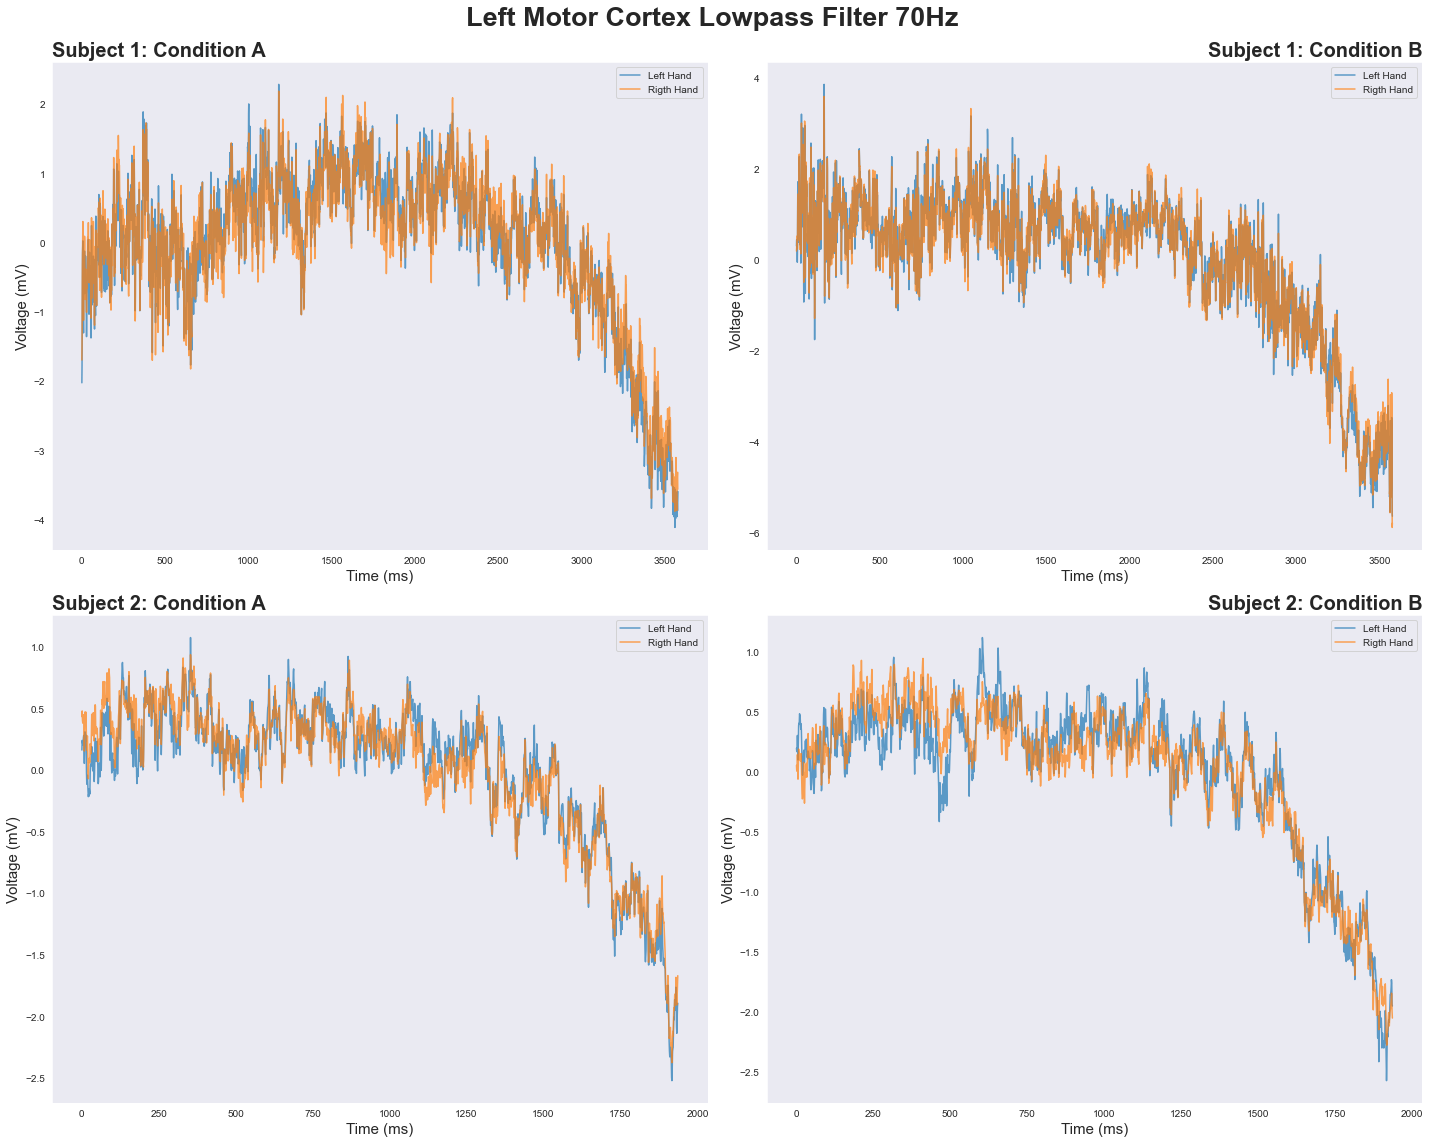

In [128]:
fig, axs = plt.subplots(2,2,figsize=(20,16), sharey=False, squeeze=True)

axs[0,0].plot(A1L,label = 'Left Hand',alpha=0.7)
axs[0,0].plot(A1R,label = 'Rigth Hand',alpha=0.7)

axs[0,0].set_title('Subject 1: Condition A',fontsize=20,fontweight = 'bold',loc='left')
axs[0,0].set_xlabel('Time (ms)',fontsize=15)
axs[0,0].set_ylabel('Voltage (mV)',fontsize=15)
axs[0,0].legend()


axs[0,1].plot(B1L,label = 'Left Hand',alpha=0.7)
axs[0,1].plot(B1R,label = 'Rigth Hand',alpha=0.7)
axs[0,1].set_title('Subject 1: Condition B',fontsize=20,fontweight = 'bold',loc='right')
axs[0,1].set_xlabel('Time (ms)',fontsize=15)
axs[0,1].set_ylabel('Voltage (mV)',fontsize=15)
axs[0,1].legend()


axs[1,0].plot(A2L,label = 'Left Hand',alpha=0.7)
axs[1,0].plot(A2R,label = 'Rigth Hand',alpha=0.7)
axs[1,0].set_title('Subject 2: Condition A',fontsize=20,fontweight = 'bold',loc='left')
axs[1,0].set_xlabel('Time (ms)',fontsize=15)
axs[1,0].set_ylabel('Voltage (mV)',fontsize=15)
axs[1,0].legend()


axs[1,1].plot(B2L,label = 'Left Hand',alpha=0.7)
axs[1,1].plot(B2R,label = 'Rigth Hand',alpha=0.7)
axs[1,1].set_title('Subject 2: Condition B',fontsize=20,fontweight = 'bold',loc='right')
axs[1,1].set_xlabel('Time (ms)',fontsize=15)
axs[1,1].set_ylabel('Voltage (mV)',fontsize=15)
axs[1,1].legend()






plt.suptitle(f'Left Motor Cortex Lowpass Filter 70Hz ', fontsize=27,fontweight="bold",va='center')
plt.tight_layout()
plt.show()

In [94]:
A1R.shape

(47,)

In [90]:
A1L.shape

(3579,)

In [119]:
np.mean(A1['X'][23,:,:][:,np.where(A1['y']==0)],axis=2).ravel().shape

(3579,)

In [ ]:
np.mean()